In [1]:
import pandas as pd
import numpy as np


# Load the combined dataframe
# Run this command to import the DataFrame from the other notebook
%store -r combinedInRangeDf

# Load the combined dataframe
#data = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/combinedInRangeDf.csv')
data = combinedInRangeDf.copy()

data.loc[data['fire'] == 'None', 'fire'] = 0
data.loc[data['fire'] == 'major', 'fire'] = 1
data.loc[data['fire'] == 'minor', 'fire'] = 1
print(data.head())

       STATION      AWND  AVG PRECIP  TOTAL PRECIP   AVG SNOW  TOTAL SNOW  \
0  USC00045091  5.363065    0.071429          0.50   0.540722    3.785052   
1  USC00045091  5.363065    0.240000          1.20   8.000000   16.000000   
2  USC00045091  5.363065    0.497143          3.48  13.200000   39.600000   
3  USC00045091  5.363065    0.741429          5.19  11.000000   33.000000   
4  USC00045091  5.309970    0.077143          0.54   0.800000    4.000000   

    AVG TEMP  AVG MAX TEMP  MAX TEMP  AVG MIN TEMP  MIN TEMP      TAVG2  \
0  47.376344     41.714286      50.0     27.142857      16.0  34.428571   
1  47.376344     42.857143      53.0     31.285714      22.0  37.071429   
2  47.376344     35.333333      46.0     11.166667       5.0  23.250000   
3  47.376344     34.857143      40.0      9.285714      -2.0  22.071429   
4  49.581029     53.142857      56.0     24.428571      18.0  38.785714   

   LATITUDE  LONGITUDE  ELEVATION       Begin         End fire fire arr  
0  33.81299 

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense
from keras.models import Sequential, load_model
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score



# Assuming `data` is your grouped dataframe and `groups` is the column containing the weather station information

# Define the features and target variable
# Define the features to be used for prediction (excluding fire-related columns)
features = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION']
target = 'fire next week'

data['fire next week'] = data.groupby('STATION')['fire'].shift(-1)
data = data.dropna()

# Split the data into training and test sets while preserving the grouping
group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_indices, test_indices = next(group_splitter.split(data[features], data[target], groups=data['STATION']))

train_data = data.iloc[train_indices]
test_data = data.iloc[test_indices]


# Normalize the data
train_stats = train_data[features].describe().transpose()

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_data[features]).astype(float)
normed_test_data = norm(test_data[features]).astype(float)

# Convert the target variable to float type
train_target = train_data['fire next week'].astype(float)
test_target = test_data['fire next week'].astype(float)

#print(normed_train_data.dtypes)
#print(train_target.dtypes)


class_counts_train = np.bincount(train_target)
total_samples_train = len(train_target)
class_weights_train = {0: total_samples_train / (2.0 * class_counts_train[0]),
                       1: total_samples_train / (2.0 * class_counts_train[1])}


# Build the model
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(features)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    normed_train_data, train_target,
    epochs=100, validation_split=0.2, verbose=0,
    class_weight = class_weights_train)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(normed_test_data, test_target)


print('Test accuracy:', test_acc)



50/50 [==============================] - 0s 2ms/step - loss: 0.3263 - accuracy: 0.8262
Test accuracy: 0.8262233138084412


50/50 [==============================] - 0s 2ms/step


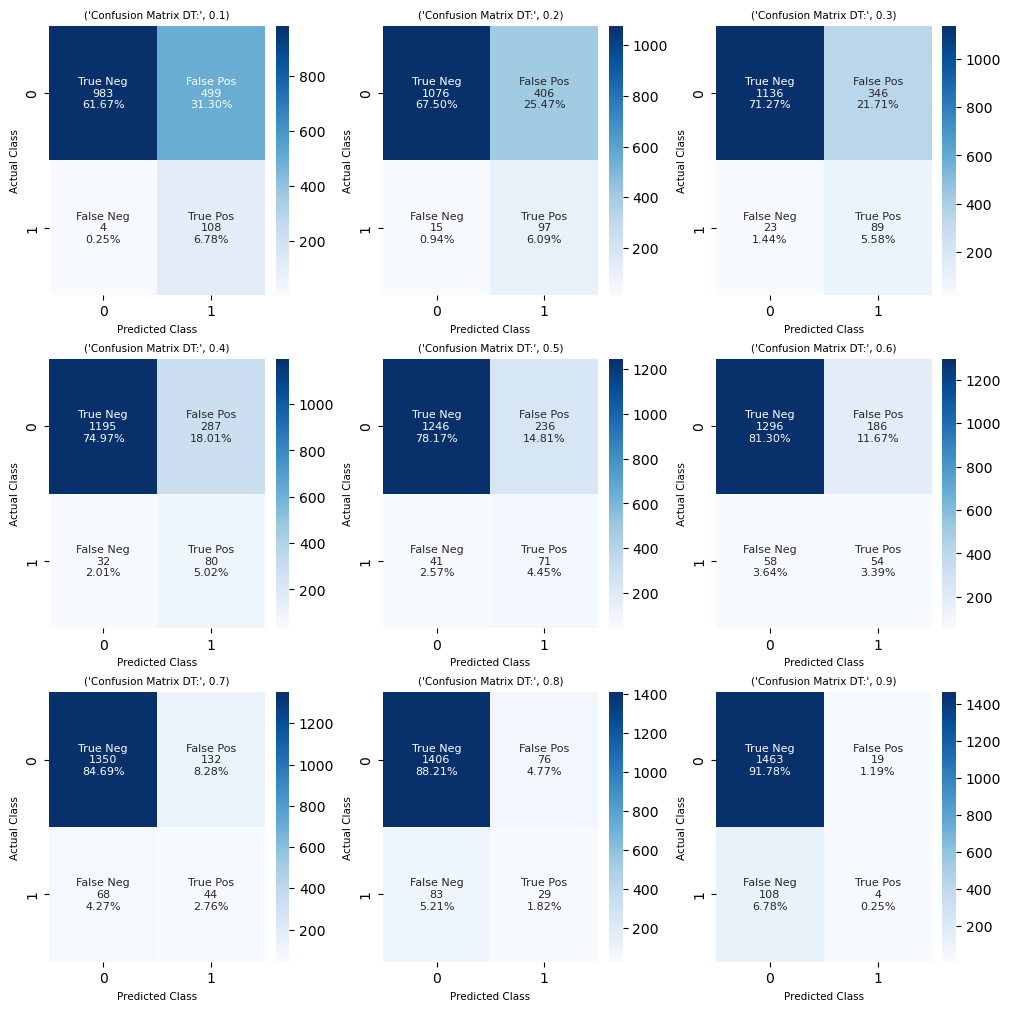

<AxesSubplot:xlabel='DecisionThreshold'>

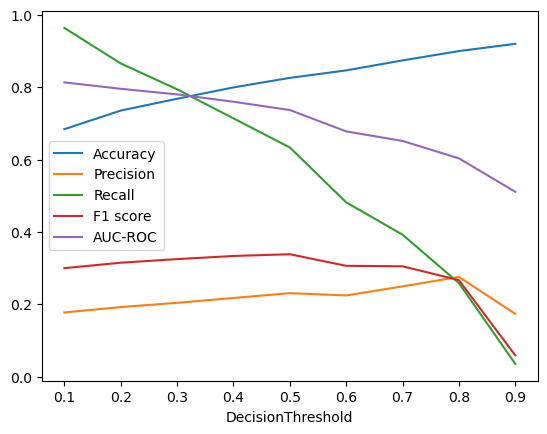

In [10]:
# Convert predictions to binary values (0 or 1)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(3,3, constrained_layout = True, figsize=(10,10))
#sns.heatmap(uniform_data, ax=ax1)
#sns.heatmap(uniform_data2, ax=ax2)
#plt.show()

test_predictions = model.predict(normed_test_data)

decisionThresholdArr = np.zeros(shape=(9,6), dtype=float) #float is less storage than double?

for i in range(9):
    decision_threshold = (i+1)/10
    binary_test_prediction_array=(test_predictions > decision_threshold).astype(int)
    precision=precision_score(test_target, binary_test_prediction_array)
    recall = recall_score(test_target, binary_test_prediction_array) #PRIORITIZE RECALL!!!!!
    f1 = f1_score(test_target, binary_test_prediction_array)
    auc_roc = roc_auc_score(test_target, binary_test_prediction_array)
    accuracy = accuracy_score(test_target, binary_test_prediction_array)
    cf_matrix = confusion_matrix(test_target, binary_test_prediction_array)
    decisionThresholdArr[i, 0]= decision_threshold
    decisionThresholdArr[i, 1]= accuracy
    decisionThresholdArr[i, 2]= precision
    decisionThresholdArr[i, 3]= recall
    decisionThresholdArr[i, 4]= f1
    decisionThresholdArr[i, 5]= auc_roc
    #print('Decision Threshold:', decision_threshold)
    group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    sns.heatmap(cf_matrix, annot=labels, annot_kws={"fontsize":8}, fmt='', cmap='Blues', ax=ax[int(i/3)][i%3])
    ax[int(i/3)][i%3].set_xlabel('Predicted Class', fontsize=7.5)
    ax[int(i/3)][i%3].set_ylabel('Actual Class', fontsize=7.5)
    title = 'Confusion Matrix DT:', decision_threshold
    ax[int(i/3)][i%3].set_title(title, size=7.5)

    #print('Accuracy:', accuracy)
    #print('Precision:', precision)
    #print('Recall:', recall)
    #print('F1 score:', f1)
    #print('AUC-ROC:', auc_roc)
    #print('----------------------------------------')


plt.show()
    
#test_predictions = (test_predictions > 0.5).astype(int)

decisionThresholdDf = pd.DataFrame(decisionThresholdArr, columns=['DecisionThreshold', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC'])
decisionThresholdDf.plot(x='DecisionThreshold', y=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC-ROC'])


